# Prewhitening

Vamos a ver como hacer prewhitening de varias series.

Un link interesante sobre [prewhitening](https://onlinecourses.science.psu.edu/stat510/node/75). Y otro [más](http://support.sas.com/documentation/cdl/en/etsug/60372/HTML/default/viewer.htm#etsug_arima_sect033.htm)

Básicamente, si tenemos $X$ e $Y$ dos series de tiempo, la función de correlación cruzada (CCF) se ve afectada tanto por la estructura interna de ambas series, su autocorrelación, así como también las tendencias compartidas que puedan tener.

Para mitigar este problema, se efectúa un proceso llamado "prewhitening", que consta de las siguientes etapas

1. Determinar un modelo para la variable $X$ y guardar los residuos de dicho modelo
2. Filtrar la variable $Y$ con el modelo planteado en el paso 1
3. Examinar la correlación cruzada entre los residuos de $X$ e $Y$. 

En el paso 1, casi siempre vamos a filtrar hacia un modelo de tipo ARIMA (Autoregressive Integrated Moving Average). Los modelos ARIMA tienen parámetros $p, d, q$



- p: Orden del modelo autoregresivo
- d: Orden de la integración (cuantas veces lo diferencié para lograr la estacionariedad)
- q: Orden del promedio móvil

En nuestro caso, los modelos que nos interesan fittear son $ARIMA(1, 0, 0)$, o sea, autoregresivos de orden 1.


Creemos una serie de tiempo autoregresiva de órden 1.


In [1]:
%matplotlib inline
import pylab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helpers import plot_autocorrelations, plot_cross_correlogram
from tsa import autoregressive, autocorrelogram

pylab.rcParams['figure.figsize'] = (18,4)



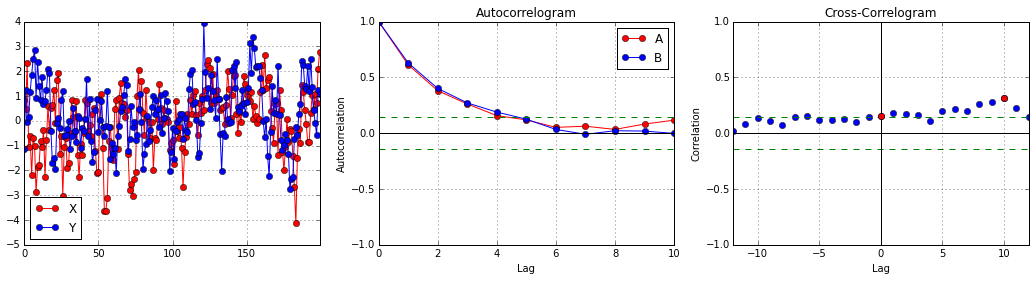

In [5]:

alpha = 0.65
n = 200

Z1 = pd.Series(np.random.randn(n))
Z2 = pd.Series(np.random.randn(n))
X = autoregressive(Z1, alpha)
Y = autoregressive(Z2, alpha)

f, ax = plt.subplots(ncols=3)

pd.DataFrame({'X': X, 'Y': Y}).plot(color=['r', 'b'], style='-o', ax=ax[0])
plot_autocorrelations(X, Y, ax=ax[1])
plot_cross_correlogram(X, Y, "", ax=ax[2], max_lag=12)


Un buen estimador para el $\alpha$ de un proceso AR(1) es $r_1$, es decir, la autocorrelación con lag 1. (Ver Chatfield, sección 4.2)

\begin{align}
\hat{\alpha} = r_1 \\
\end{align}


In [6]:
acf = autocorrelogram(X)


print acf[1]

0.612086586913


Recordemos que nuestro proceso es de la forma $X_t = c + \alpha X_{t-1} + \epsilon_t$. Si $|\alpha| < 1$, el proceso es fuertemente estacionario. Asumiendo ésto, y tomando esperanza de ambos lados:

\begin{align}
E[X_t] &= E[c] + \alpha E[X_{t-1}] + E[ \epsilon_{t} ] \\
E[X_t] &= c + \alpha E[X_{t-1}] \tag*{Ya que $\epsilon_t$ es ruido blanco} \\
E[X_t] - \alpha E[X_{t-1}] &= c \\
(1 - \alpha) E[X_t] &= c \tag*{Ya que es estacionaria $\rightarrow$ tienen esperanza constante} \\ 
E[X_t] &= \frac{c}{1-\alpha}
\end{align}

Luego, si tomamos que $\bar{X} \simeq \frac{c}{1-\alpha}$, puede verse que

\begin{align}
\epsilon_t \simeq (X_t - \bar{X})  - \alpha (X_{t-1} - \bar{X})\\
\end{align}

Utilicemos esta ecuación para filtrar la serie X

In [7]:
from tsa import autoregressive_prewhitening

rX, rY = autoregressive_prewhitening(X, Y)

Veamos, como era esperable, que el correlograma cruzado arroja valor significativo alguno, ya que ambas series eran "independientes"

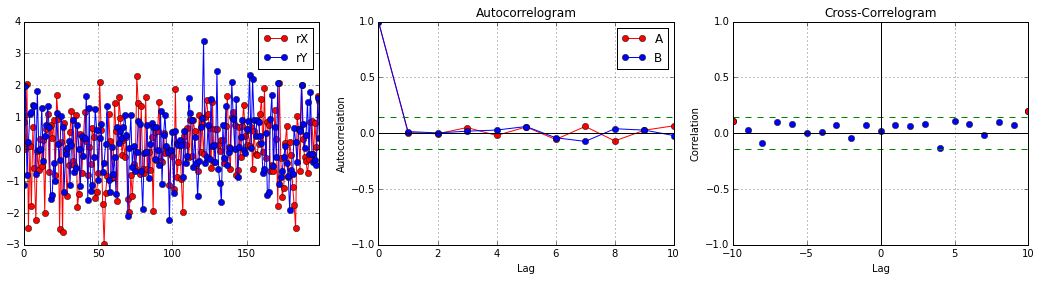

In [8]:

f, ax = plt.subplots(ncols=3)

pd.DataFrame({'rX': rX, 'rY': rY}).plot(color=['r', 'b'], style='-o', ax=ax[0])
plot_autocorrelations(rX, rY, ax=ax[1])
plot_cross_correlogram(rX, rY, "", ax=ax[2], max_lag=10)

In [15]:
print pd.DataFrame({'X': X, 'rX': rX, 'Z': Z1})

print rX.corr(Z1)

            X         Z        rX
0   -0.415884 -0.415884 -0.371337
1    0.036422  0.036422  0.345012
2   -1.210295 -1.233969 -1.188872
3   -1.104645 -0.317953 -0.291685
4    0.120846  0.838865  0.866728
5   -1.642750 -1.721300 -1.674927
6   -0.936510  0.131278  0.151014
7   -0.038099  0.570632  0.601035
8    0.820626  0.845391  0.889362
9    2.161987  1.628580  1.685522
10  -0.075248 -1.480540 -1.403340
11  -1.358044 -1.309133 -1.265722
12  -0.077155  0.805574  0.829610
13  -1.273153 -1.223002 -1.179621
14   0.141413  0.968963  0.994282
15   1.223509  1.131590  1.178273
16   1.029037  0.233756  0.296782
17   0.348470 -0.320404 -0.260315
18  -0.944517 -1.171023 -1.121213
19   1.991392  2.605328  2.635610
20  -0.216024 -1.510428 -1.435805
21  -0.257634 -0.117219 -0.075934
22  -0.625612 -0.458150 -0.417494
23   1.081659  1.488306  1.523405
24  -0.398712 -1.101790 -1.040906
25   0.391496  0.650659  0.689184
26   0.978434  0.723961  0.774422
27   1.153431  0.517449  0.576774
28   0.948352 